In [22]:
import numpy as np
import matplotlib.pyplot as plt

# ----- make nice figures -----
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300
from cycler import cycler
COLORS = ['#F00D2C', '#242482', '#0071BE', '#4E8F00', '#553C67', '#DA5319']
default_cycler = cycler(color=COLORS)
plt.rc('axes', prop_cycle=default_cycler) 
# -----------------------------

In [2]:
data = np.loadtxt('data/perovskite_data.txt')

# Shuffle data
I_perm = np.random.permutation(len(data))
data = data[I_perm, :]

# Class data - whether we form Perovskite or not
c = data[:, 0]

# Extract all but the 0-th column
X = data[:, 1:]

# Normalize data
X = (X - np.mean(X, axis=0))/np.std(X, axis = 0)


In [3]:
# Training, validation and testing set
num_points = len(c)
num_train = int(0.8*0.8*num_points)
num_valid = int(0.8*0.2*num_points)
num_test = len(c) - num_train - num_valid

X_train = X[:num_train, :]
c_train = c[:num_train]

X_valid = X[num_train:(num_train + num_valid), :]
c_valid = c[num_train:(num_train + num_valid)]

# get the last "num_test" rows
X_test = X[-num_test:, :]
c_test = c[-num_test:]

print("         Total data size: " + str(num_points))
print("  Training data set size: " + str(num_train))
print("Validation data set size: " + str(num_valid))
print("   Testing data set size: " + str(num_test))

         Total data size: 355
  Training data set size: 227
Validation data set size: 56
   Testing data set size: 72


## Kernel SVM

In [4]:
from sklearn.svm import SVC
svm_model = SVC(kernel='poly', degree = 4, gamma = 'auto')
svm_model.fit(X_train, c_train)
c_model = svm_model.predict(X_valid)

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

score = f1_score(c_model, c_valid)
print("score " + str(score))

score 0.9166666666666666


Text(0, 0.5, 'F1 Score')

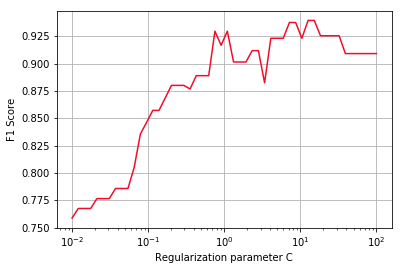

In [6]:
C_vals = np.logspace(-2, 2)
f1_scores = np.zeros(len(C_vals))

for i, C in enumerate(C_vals):
    svm_model = SVC(kernel='poly', degree = 4, gamma = 'auto', C = C)
    svm_model.fit(X_train, c_train)
    c_model = svm_model.predict(X_valid)
    f1_scores[i] = f1_score(c_model, c_valid)

plt.plot(C_vals, f1_scores)
plt.grid()
plt.xscale('log')
plt.xlabel('Regularization parameter C')
plt.ylabel('F1 Score')

In [7]:
i_best = np.argmax(f1_scores)
C_best = C_vals[i_best]
print(C_best)

# train final model
svm_model = SVC(kernel='poly', degree = 4, gamma = 'auto', C = C_best)
svm_model.fit(X_train, c_train)

# Predict accuracy on test data
c_model = svm_model.predict(X_test)
accuracy = accuracy_score(c_model, c_test)
f1 = f1_score(c_model, c_test)
print("Estimted accuracy for new data = " + str(100.0*accuracy) + "%")
print("Estimted f1 score for new data = " + str(100.0*f1) + "%")

12.648552168552959
Estimted accuracy for new data = 93.05555555555556%
Estimted f1 score for new data = 95.41284403669724%


# Classification Trees

Documentation:
http://www.scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [13]:
# Classification tree model
from sklearn.tree import DecisionTreeClassifier

# train with training data
model = DecisionTreeClassifier(criterion='entropy')
model.fit(X_train, c_train)

c_model = model.predict(X_valid)
score = accuracy_score(c_model, c_valid)
print(score)

0.9285714285714286


In [16]:
# Try a different "uniformity measure"
model = DecisionTreeClassifier(criterion='gini')
model.fit(X_train, c_train)
c_model = model.predict(X_valid)
score = accuracy_score(c_model, c_valid)
print(score)

0.8928571428571429


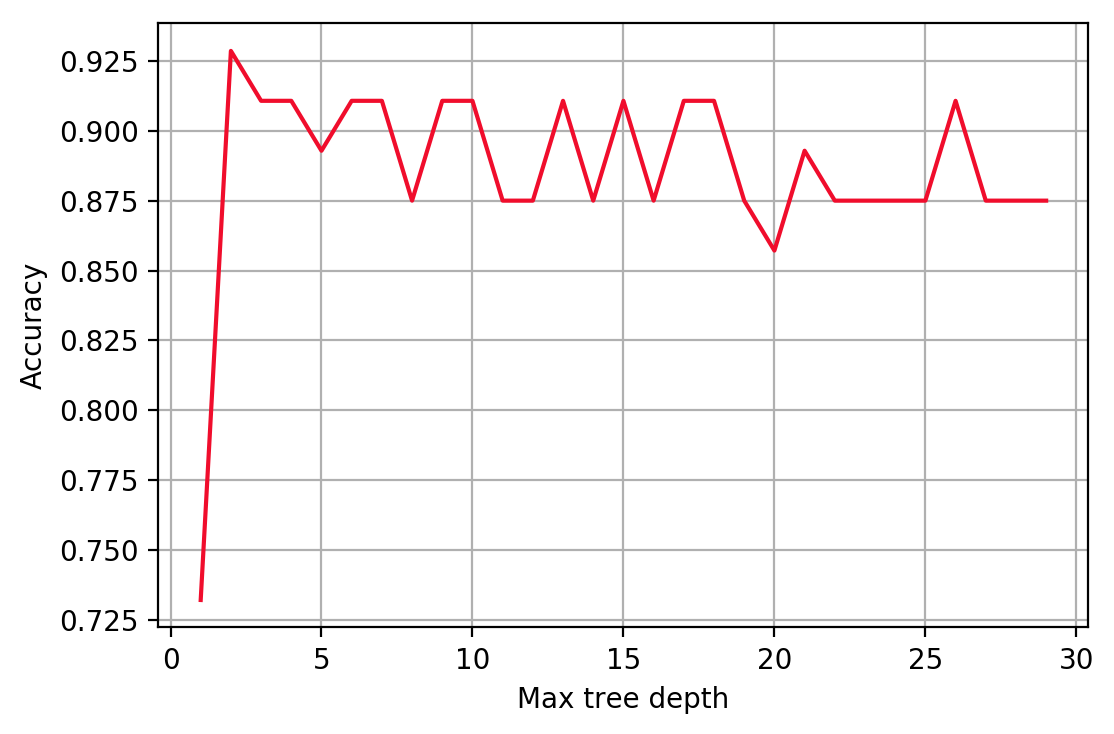

In [17]:
# Vary "max_depth"
depths = np.arange(1, 30)
scores = np.zeros(len(depths))

for i, d in enumerate(depths):
    model = DecisionTreeClassifier(criterion='gini', max_depth = d)
    model.fit(X_train, c_train)
    c_model = model.predict(X_valid)
    scores[i] = accuracy_score(c_model, c_valid)

plt.plot(depths, scores)
plt.xlabel('Max tree depth')
plt.ylabel('Accuracy')
plt.grid()

In [18]:
# Predict accuracy on test data
model = DecisionTreeClassifier(criterion='gini', max_depth = 6)
model.fit(X_train, c_train)
c_model = model.predict(X_test)
accuracy = accuracy_score(c_model, c_test)
f1 = f1_score(c_model, c_test)
print("Estimted accuracy for new data = " + str(100.0*accuracy) + "%")
print("Estimted f1 score for new data = " + str(100.0*f1) + "%")

Estimted accuracy for new data = 98.61111111111111%
Estimted f1 score for new data = 99.04761904761905%


# Analyzing the decision tree

[Text(492.35294117647055, 560.8571428571429, 'X[3] <= -0.814\nentropy = 0.468\nsamples = 227\nvalue = [85, 142]'),
 Text(437.6470588235294, 474.57142857142856, 'entropy = 0.0\nsamples = 38\nvalue = [38, 0]'),
 Text(547.0588235294117, 474.57142857142856, 'X[10] <= 0.172\nentropy = 0.374\nsamples = 189\nvalue = [47, 142]'),
 Text(273.52941176470586, 388.2857142857143, 'X[10] <= -0.638\nentropy = 0.175\nsamples = 155\nvalue = [15, 140]'),
 Text(109.41176470588235, 302.0, 'X[11] <= -0.22\nentropy = 0.198\nsamples = 9\nvalue = [8, 1]'),
 Text(54.705882352941174, 215.71428571428567, 'entropy = 0.0\nsamples = 8\nvalue = [8, 0]'),
 Text(164.11764705882354, 215.71428571428567, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(437.6470588235294, 302.0, 'X[4] <= -0.41\nentropy = 0.091\nsamples = 146\nvalue = [7, 139]'),
 Text(273.52941176470586, 215.71428571428567, 'X[2] <= -0.511\nentropy = 0.365\nsamples = 25\nvalue = [6, 19]'),
 Text(218.8235294117647, 129.4285714285714, 'entropy = 0.0\nsam

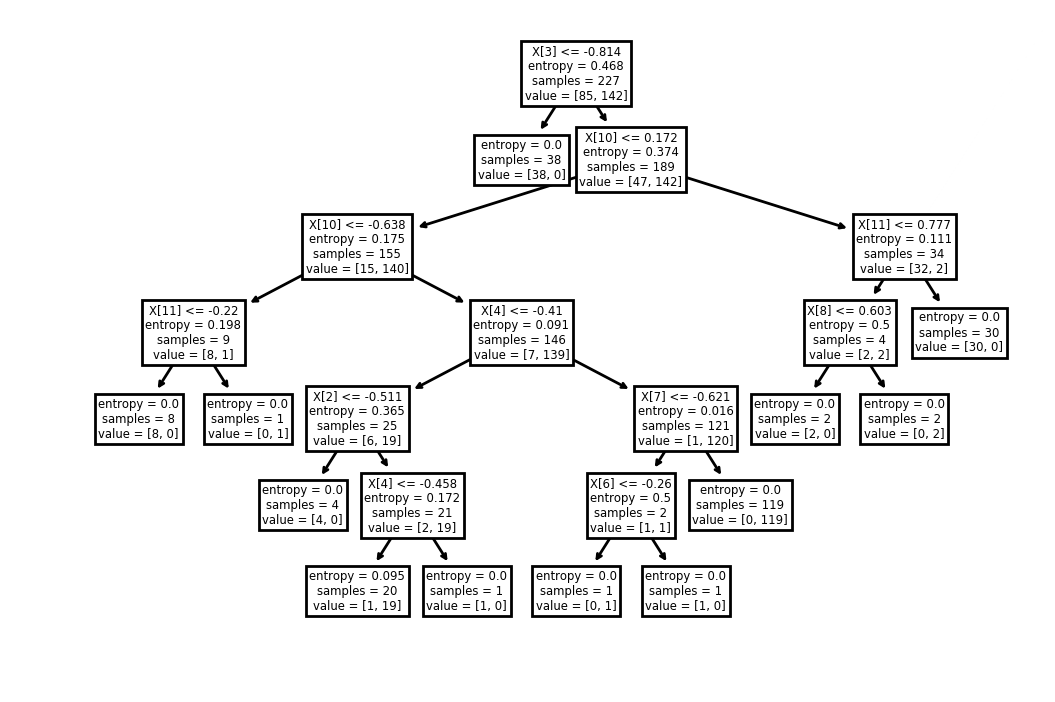

In [19]:
from sklearn.tree import plot_tree
plot_tree(model)

[Text(738.5294117647059, 841.2857142857143, 'dA-O <= -0.814\nentropy = 0.468\nsamples = 227\nvalue = [85, 142]'),
 Text(656.4705882352941, 711.8571428571429, 'entropy = 0.0\nsamples = 38\nvalue = [38, 0]'),
 Text(820.5882352941177, 711.8571428571429, 'rA/rB <= 0.172\nentropy = 0.374\nsamples = 189\nvalue = [47, 142]'),
 Text(410.29411764705884, 582.4285714285714, 'rA/rB <= -0.638\nentropy = 0.175\nsamples = 155\nvalue = [15, 140]'),
 Text(164.11764705882354, 453.00000000000006, 't_BV <= -0.22\nentropy = 0.198\nsamples = 9\nvalue = [8, 1]'),
 Text(82.05882352941177, 323.57142857142867, 'entropy = 0.0\nsamples = 8\nvalue = [8, 0]'),
 Text(246.1764705882353, 323.57142857142867, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(656.4705882352941, 453.00000000000006, 'B-EN - O-EN <= -0.41\nentropy = 0.091\nsamples = 146\nvalue = [7, 139]'),
 Text(410.29411764705884, 323.57142857142867, 'A-ionicity <= -0.511\nentropy = 0.365\nsamples = 25\nvalue = [6, 19]'),
 Text(328.2352941176471, 194.1

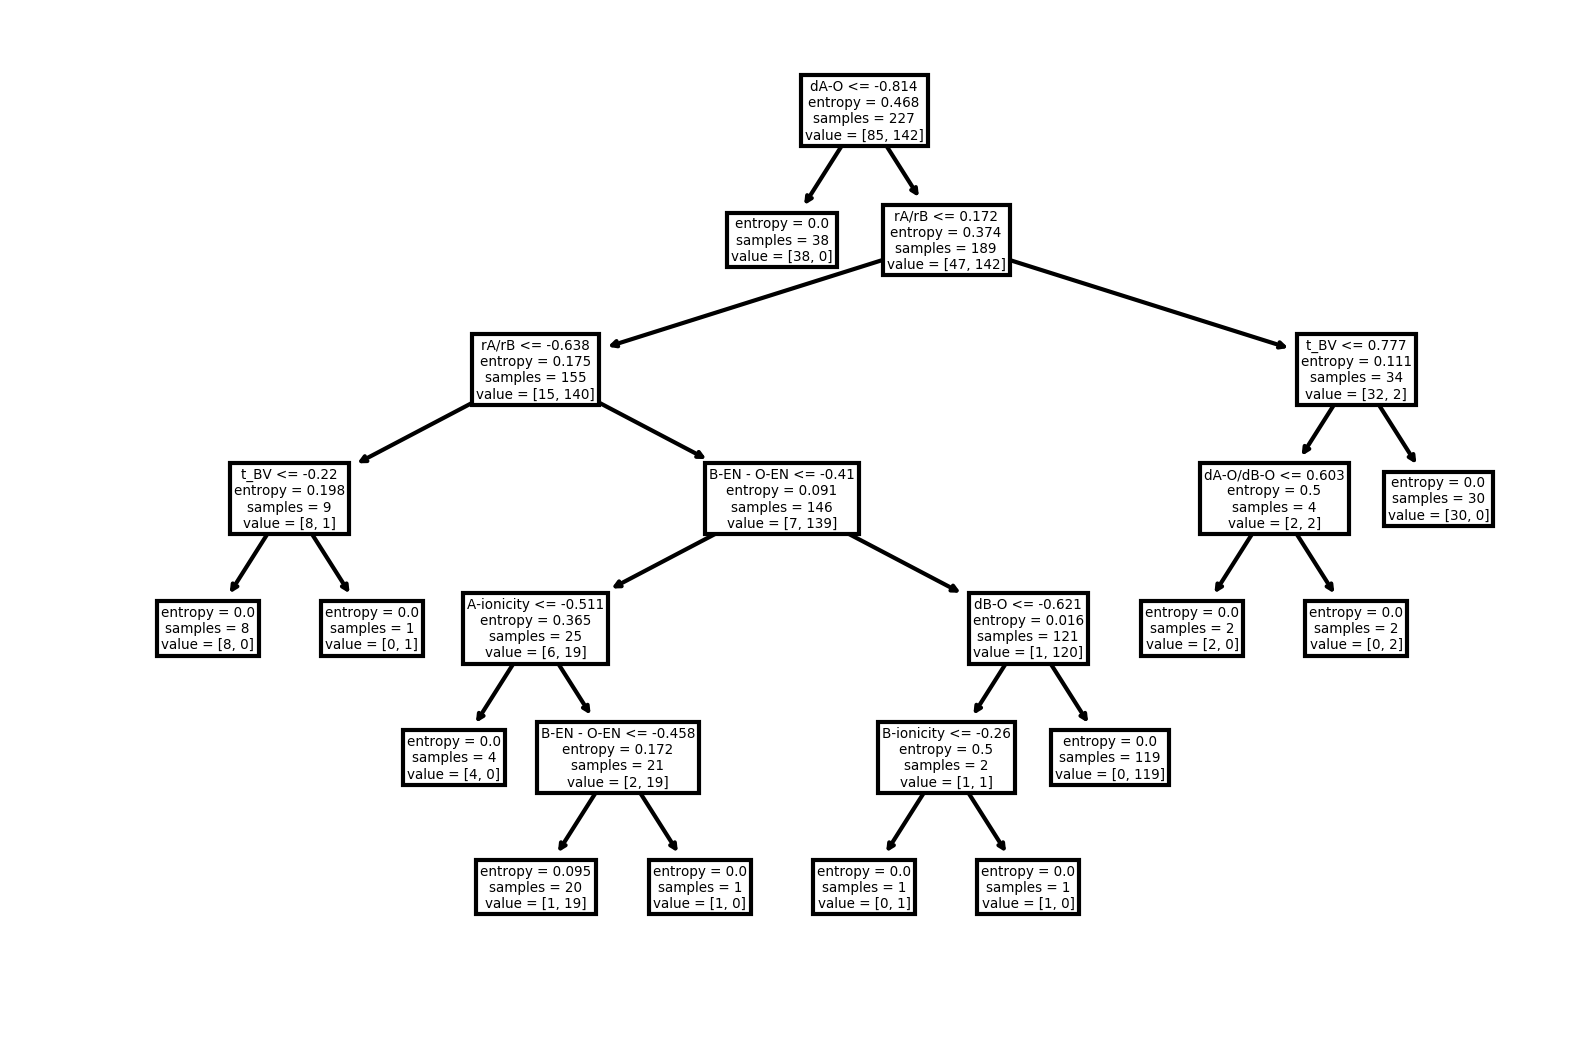

In [23]:
feature_names = ["A-EN - O-EN", "rA/rO", "A-ionicity", "dA-O", "B-EN - O-EN", "rB/rO", "B-ionicity", "dB-O", "dA-O/dB-O", "A-EN - B-EN", "rA/rB", "t_BV", "t_IR", "GII"]
plot_tree(model, feature_names = feature_names )

## Feature importance

In [24]:
importance = model.feature_importances_
print(importance)

[0.         0.         0.05266911 0.34199577 0.03776529 0.
 0.00957454 0.00941629 0.01914909 0.         0.49551224 0.03391767
 0.         0.        ]


Text(0.5, 0, 'Importance')

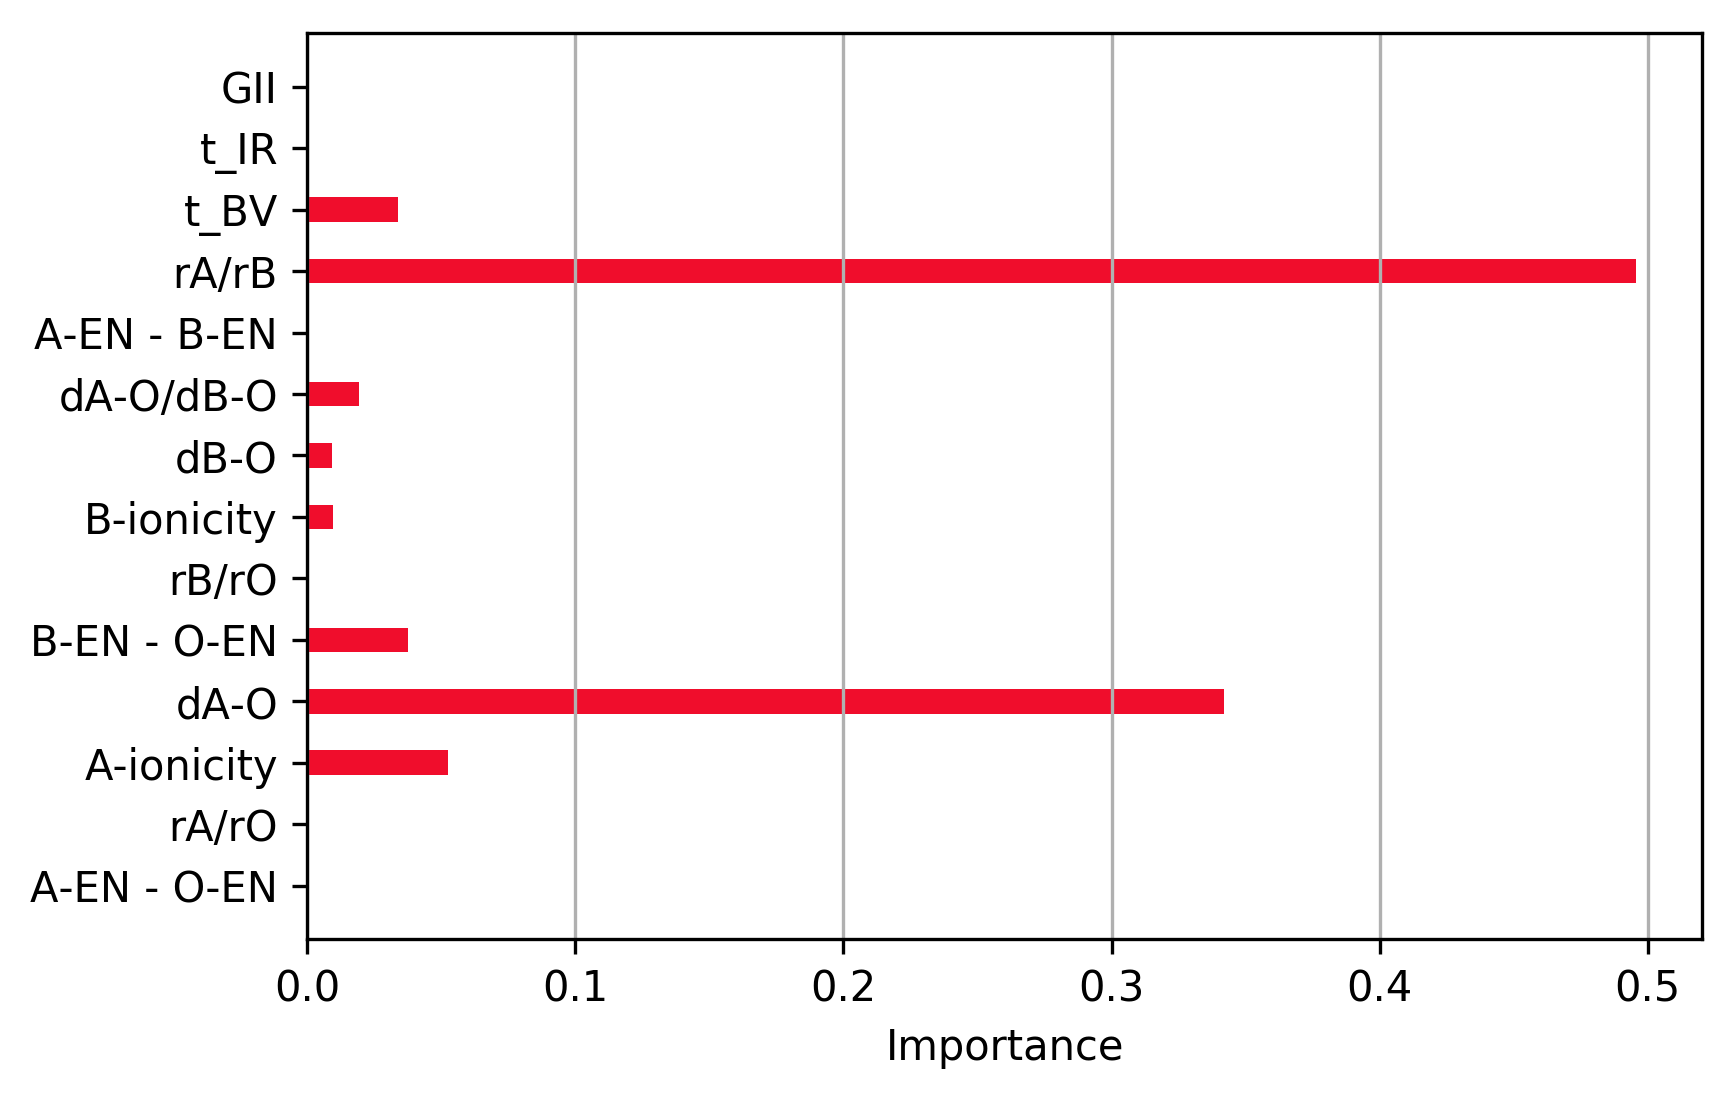

In [25]:
x_plot = [2*i for i in range(len(importance))]
plt.barh(x_plot, model.feature_importances_)
plt.yticks(x_plot, feature_names)
plt.grid(axis = 'x')
plt.xlabel('Importance')